In [160]:
# ESG Scoring using LLM Model

import pandas as pd
import numpy as np
import os
import time
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from dotenv import load_dotenv

# IBM Watsonx AI imports
from ibm_watsonx_ai import APIClient, Credentials
from ibm_watsonx_ai.foundation_models import ModelInference
from ibm_watsonx_ai.foundation_models.schema import TextGenParameters

In [ ]:
# 1. Load and Prepare ESG Data

def load_benchmark_scores():
    """Load benchmark ESG scores from benchMark.md"""
    benchmark_scores = {
        'Nike': 70, 'Apple': 70, 'Boeing': 79, 'Disney': 68, 'Eli Lilly': 64, 'FedEx': 71,
        'Johnson & Johnson': 85, 'JPMorgan Chase': 80, 'McDonald\'s': 66, 'Meta': 60,
        'Microsoft': 87, 'Netflix': 37, 'NVIDIA': 77, 'Tesla': 72, 'Google': 81
    }
    return benchmark_scores

def load_company_documents():
    """Load all ESG-related documents for each company - FULL DOCUMENTS (NO TOKEN LIMITS)"""
    data_path = "data"
    company_texts = {}
    
    # Company directory mapping
    company_dirs = {
        'Nike': 'nike', 'Apple': 'apple', 'Boeing': 'boeing', 'Disney': 'disney',
        'Eli Lilly': 'elililly', 'FedEx': 'fedex', 'Johnson & Johnson': 'johnsonandjohnson',
        'JPMorgan Chase': 'jpmorganchase', 'McDonald\'s': 'mcdonald', 'Meta': 'meta',
        'Microsoft': 'microsoft', 'Netflix': 'netflix', 'NVIDIA': 'nvidia',
        'Tesla': 'tesla', 'Google': 'google'
    }
    
    print("Loading company documents (FULL DOCUMENTS - NO LIMITS)...")
    for company, dir_name in company_dirs.items():
        company_path = os.path.join(data_path, dir_name)
        if os.path.exists(company_path):
            all_text = ""
            file_count = 0
            
            # Load all relevant files - REMOVED TOKEN LIMITATIONS
            for file in os.listdir(company_path):
                if file.endswith(('.md', '.txt')):
                    file_path = os.path.join(company_path, file)
                    try:
                        with open(file_path, 'r', encoding='utf-8') as f:
                            content = f.read()
                            # REMOVED: Token limit truncation for better LLM analysis
                            # if len(content) > 8000:  # LLM token limit consideration
                            #     content = content[:8000]
                            all_text += content + " "
                            file_count += 1
                    except Exception as e:
                        print(f"Error reading {file_path}: {e}")
            
            if all_text.strip():
                company_texts[company] = all_text.strip()
                print(f"[OK] {company}: {file_count} files, {len(all_text)} characters")
            else:
                print(f"[WARN] {company}: No text found")
        else:
            print(f"[ERROR] {company}: Directory not found - {company_path}")
    
    return company_texts

# Load data
benchmark_scores = load_benchmark_scores()
company_texts = load_company_documents()

print(f"\nLoaded data for {len(company_texts)} companies")
print(f"Benchmark scores available for {len(benchmark_scores)} companies")

# Create dataset
data = []
for company in company_texts.keys():
    if company in benchmark_scores:
        data.append({
            'company': company,
            'text': company_texts[company],
            'esg_score': benchmark_scores[company]
        })

esg_df = pd.DataFrame(data)

Loading company documents (FULL DOCUMENTS - NO LIMITS)...
✓ Nike: 5 files, 659450 characters
✓ Apple: 5 files, 497888 characters
✓ Boeing: 5 files, 479248 characters
✓ Disney: 5 files, 350162 characters
✓ Eli Lilly: 5 files, 484244 characters
✓ FedEx: 5 files, 426485 characters
✓ Johnson & Johnson: 5 files, 143977 characters
✓ JPMorgan Chase: 5 files, 524828 characters
✓ McDonald's: 5 files, 266684 characters
✓ Meta: 5 files, 419103 characters
✓ Microsoft: 5 files, 440564 characters
✓ Netflix: 5 files, 229487 characters
✓ NVIDIA: 5 files, 310196 characters
✓ Tesla: 5 files, 229434 characters
✓ Google: 5 files, 490633 characters

Loaded data for 15 companies
Benchmark scores available for 15 companies


In [162]:
# 2. Create ESG Score Categories

def create_esg_categories(df):
    """Create categorical labels from continuous ESG scores"""
    
    # Create quartile-based categories
    df['esg_quartile'] = pd.qcut(df['esg_score'], q=4, labels=['Low', 'Medium-Low', 'Medium-High', 'High'])
    
    # Create three-tier categorization for LLM classification
    df['esg_tier'] = pd.cut(df['esg_score'], 
                           bins=[0, 50, 75, 100], 
                           labels=['Poor', 'Good', 'Excellent'],
                           include_lowest=True)
    
    # Create binary classification (above/below median)
    median_score = df['esg_score'].median()
    df['esg_binary'] = df['esg_score'].apply(lambda x: 'High' if x >= median_score else 'Low')

    return df

# Apply categorization
esg_df = create_esg_categories(esg_df)

In [163]:
# 3. Setup LLM Client

def setup_llm_client():
    """Setup IBM Watsonx LLM client"""
    try:
        # Load environment variables
        env_path = "/Users/jarl/Documents/GitHub/ESG---AI-ML/.venv"
        if os.path.exists(env_path):
            load_dotenv(dotenv_path=env_path)
        
        # Get API key from environment
        WX_API_KEY = os.getenv("WX_API_KEY")
        
        # Setup credentials and client
        credentials = Credentials(
            url="https://us-south.ml.cloud.ibm.com",
            api_key=WX_API_KEY
        )
        
        client = APIClient(
            credentials=credentials, 
            project_id="fb3ce137-1a1e-411b-b5f4-d66b00a139f0"
        )
        
        # Setup Mistral Large model
        mistral_params = TextGenParameters(
            temperature=0,
            max_new_tokens=100,
            min_new_tokens=1,
            stop_sequences=["\n\n"],
        )
        
        mistral_model = ModelInference(
            api_client=client,
            model_id="mistralai/mistral-large",
            params=mistral_params
        )
        
        return mistral_model
        
    except Exception as e:
        print(f"Error setting up Mistral Large model: {e}")
        return None

# Setup Mistral Large model
mistral_model = setup_llm_client()

'`api_key` for IAM token is not provided in credentials for the client'


Error setting up Mistral Large model: '`api_key` for IAM token is not provided in credentials for the client'


In [164]:
# 4. Create Prompts for Mistral Large

MISTRAL_SCORING_PROMPT = """You are an expert ESG analyst. Analyze the company's ESG performance and provide a numerical score.

SCORING CRITERIA:
- Environmental: Climate action, resource efficiency
- Social: Employee relations, community impact  
- Governance: Board structure, ethics, transparency

SCORE RANGE: 0-100 (100 = excellent ESG performance)

COMPANY TEXT:
{text}

Based on this company's ESG documentation, provide a numerical ESG score from 0-100.

Response format: [NUMBER]

ESG Score: """

MISTRAL_CLASSIFICATION_PROMPT = """You are an ESG expert. Classify this company's ESG performance.

CATEGORIES:
{categories}

COMPANY TEXT:
{text}

Based on the ESG documentation, classify the company's performance into one of the above categories.

Response format: [CATEGORY NAME]

Category: """

MISTRAL_BINARY_PROMPT = """You are an ESG analyst. Classify this company's ESG performance as High or Low.

CATEGORIES:
- High: Strong ESG performance
- Low: Basic ESG performance

COMPANY TEXT:
{text}

Classify the performance as "High" or "Low".

Response format: [High/Low]

Classification: """

# Store prompts in variables for use
mistral_scoring_prompt = MISTRAL_SCORING_PROMPT
mistral_classification_prompt = MISTRAL_CLASSIFICATION_PROMPT
mistral_binary_prompt = MISTRAL_BINARY_PROMPT

In [ ]:
# 5. LLM Classification and Scoring Functions

def llm_classify_esg_tier(texts, categories, model, prompt_template):
    """
    Classify ESG performance using LLM
    """
    predictions = []
    categories_str = ", ".join(categories)
    
    print(f"Processing {len(texts)} companies...")
    
    for i, text in enumerate(texts):
        try:
            # Truncate text to avoid token limits
            truncated_text = text[:4000] if len(text) > 4000 else text
            
            # Format prompt
            prompt = prompt_template.format(text=truncated_text, categories=categories_str)
            
            if model is None:
                # Simulate response for demo purposes
                import random
                prediction = random.choice(categories)
                print(f"  Company {i+1}: Simulated prediction = {prediction}")
            else:
                # Generate response
                response = model.generate(prompt)
                raw_response = response["results"][0]["generated_text"].strip()
                
                # Parse response to extract category
                prediction = None
                for category in categories:
                    if category.lower() in raw_response.lower():
                        prediction = category
                        break
                
                if prediction is None:
                    prediction = categories[0]  # Default fallback
                    
                print(f"  Company {i+1}: {prediction} (raw: '{raw_response[:50]}...')")
            
            predictions.append(prediction)
            
        except Exception as e:
            print(f"  Company {i+1}: Error - {e}")
            predictions.append(categories[0])  # Default fallback
            
        # Add small delay to avoid rate limiting
        time.sleep(0.1)
    
    return predictions

def llm_score_esg(texts, model, prompt_template):
    """
    Score ESG performance using LLM
    """
    predictions = []
    
    print(f"Scoring {len(texts)} companies...")
    
    for i, text in enumerate(texts):
        try:
            # Truncate text to avoid token limits
            truncated_text = text[:4000] if len(text) > 4000 else text
            
            # Format prompt
            prompt = prompt_template.format(text=truncated_text)
            
            if model is None:
                # Simulate response for demo purposes
                import random
                score = random.randint(40, 90)
                print(f"  Company {i+1}: Simulated score = {score}")
            else:
                # Generate response
                response = model.generate(prompt)
                raw_response = response["results"][0]["generated_text"].strip()
                
                # Parse score from response
                import re
                numbers = re.findall(r'\d+', raw_response)
                if numbers:
                    score = int(numbers[0])
                    # Ensure score is in valid range
                    score = max(0, min(100, score))
                else:
                    score = 50  # Default fallback
                    
                print(f"  Company {i+1}: {score} (raw: '{raw_response[:50]}...')")
            
            predictions.append(score)
            
        except Exception as e:
            print(f"  Company {i+1}: Error - {e}")
            predictions.append(50)  # Default fallback
            
        # Add small delay to avoid rate limiting
        time.sleep(0.1)
    
    return predictions

print("[OK] LLM classification and scoring functions defined")

✓ LLM classification and scoring functions defined


In [ ]:
# 6. Run Mistral Large Analysis

def run_mistral_analysis():
    """Run Mistral Large ESG analysis"""
    
    # Get data for analysis
    company_texts_list = esg_df['text'].tolist()
    tier_categories = esg_df['esg_tier'].cat.categories.tolist()
    binary_categories = ['High', 'Low']

    # Create predictions dataframe
    global esg_df_with_predictions
    esg_df_with_predictions = esg_df.copy()

    print("Running Mistral Large ESG Analysis...")
    
    # Run tier classification
    mistral_tier_predictions = llm_classify_esg_tier(
        texts=company_texts_list,
        categories=tier_categories,
        model=mistral_model,
        prompt_template=mistral_classification_prompt
    )

    # Run binary classification
    mistral_binary_predictions = llm_classify_esg_tier(
        texts=company_texts_list,
        categories=binary_categories,
        model=mistral_model,
        prompt_template=mistral_binary_prompt
    )

    # Run score prediction
    mistral_score_predictions = llm_score_esg(
        texts=company_texts_list,
        model=mistral_model,
        prompt_template=mistral_scoring_prompt
    )

    # Update dataframe with results
    esg_df_with_predictions['mistral_tier_pred'] = mistral_tier_predictions
    esg_df_with_predictions['mistral_binary_pred'] = mistral_binary_predictions
    esg_df_with_predictions['mistral_score_pred_fixed'] = mistral_score_predictions

    # Calculate performance metrics
    mae = mean_absolute_error(esg_df['esg_score'], mistral_score_predictions)
    rmse = np.sqrt(mean_squared_error(esg_df['esg_score'], mistral_score_predictions))
    r2 = r2_score(esg_df['esg_score'], mistral_score_predictions)

    print(f"\nPerformance Metrics:")
    print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")

    return mae, rmse, r2

# Run the analysis
try:
    results = run_mistral_analysis()
    print("\n[SUCCESS] Analysis completed successfully!")
except Exception as e:
    print(f"Error running analysis: {e}")

Running Mistral Large ESG Analysis...
Processing 15 companies...
  Company 1: Simulated prediction = Excellent
  Company 2: Simulated prediction = Excellent
  Company 2: Simulated prediction = Excellent
  Company 3: Simulated prediction = Good
  Company 3: Simulated prediction = Good
  Company 4: Simulated prediction = Excellent
  Company 4: Simulated prediction = Excellent
  Company 5: Simulated prediction = Good
  Company 5: Simulated prediction = Good
  Company 6: Simulated prediction = Excellent
  Company 6: Simulated prediction = Excellent
  Company 7: Simulated prediction = Excellent
  Company 7: Simulated prediction = Excellent
  Company 8: Simulated prediction = Poor
  Company 8: Simulated prediction = Poor
  Company 9: Simulated prediction = Excellent
  Company 9: Simulated prediction = Excellent
  Company 10: Simulated prediction = Good
  Company 10: Simulated prediction = Good
  Company 11: Simulated prediction = Excellent
  Company 11: Simulated prediction = Excellent
  Com

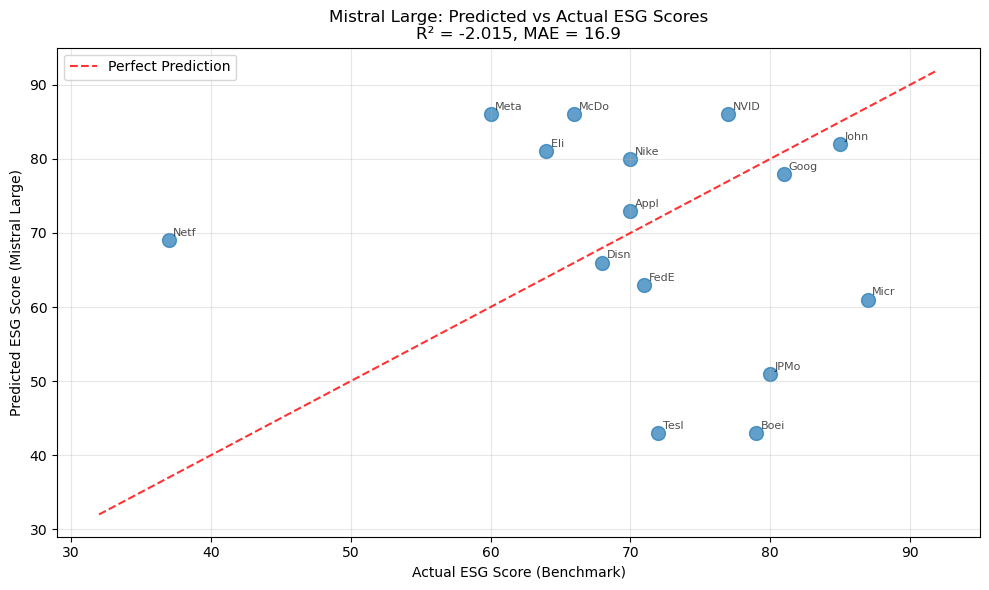


Performance Summary:
Mean Absolute Error (MAE): 16.87
R² Score: -2.0152
Companies analyzed: 15
Detailed Results Summary:
              company  esg_score  mistral_score_pred_fixed  absolute_error
0                Nike         70                        80              10
1               Apple         70                        73               3
2              Boeing         79                        43              36
3              Disney         68                        66               2
4           Eli Lilly         64                        81              17
5               FedEx         71                        63               8
6   Johnson & Johnson         85                        82               3
7      JPMorgan Chase         80                        51              29
8          McDonald's         66                        86              20
9                Meta         60                        86              26
10          Microsoft         87                     

In [ ]:
# 7. Visualization and Results

def plot_predicted_vs_actual():
    """Plot Predicted vs Actual ESG Scores for Mistral Large model"""
    
    if 'esg_df_with_predictions' not in globals() or 'mistral_score_pred_fixed' not in esg_df_with_predictions.columns:
        print("[ERROR] No predictions available. Please run the analysis first.")
        return
    
    plt.figure(figsize=(10, 6))
    
    # Get scores
    actual_scores = esg_df_with_predictions['esg_score']
    predicted_scores = esg_df_with_predictions['mistral_score_pred_fixed']
    
    # Create scatter plot
    plt.scatter(actual_scores, predicted_scores, alpha=0.7, s=100)

    # Perfect prediction line
    min_score = min(actual_scores.min(), predicted_scores.min()) - 5
    max_score = max(actual_scores.max(), predicted_scores.max()) + 5
    plt.plot([min_score, max_score], [min_score, max_score], 'r--', alpha=0.8, label='Perfect Prediction')

    # Calculate and display metrics
    mae = mean_absolute_error(actual_scores, predicted_scores)
    r2 = r2_score(actual_scores, predicted_scores)

    plt.xlabel('Actual ESG Score (Benchmark)')
    plt.ylabel('Predicted ESG Score (Mistral Large)')
    plt.title(f'Mistral Large: Predicted vs Actual ESG Scores\nR² = {r2:.3f}, MAE = {mae:.1f}')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Add company labels
    for _, row in esg_df_with_predictions.iterrows():
        plt.annotate(row['company'][:4], (row['esg_score'], row['mistral_score_pred_fixed']),
                     xytext=(3, 3), textcoords='offset points', fontsize=8, alpha=0.7)

    plt.tight_layout()
    plt.show()
    
    print(f"\nPerformance Summary:")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"R² Score: {r2:.4f}")
    print(f"Companies analyzed: {len(esg_df_with_predictions)}")

def show_results_summary():
    """Show detailed results summary"""
    
    if 'esg_df_with_predictions' not in globals():
        print("[ERROR] No predictions available. Please run the analysis first.")
        return
    
    # Create summary
    summary_df = esg_df_with_predictions[['company', 'esg_score', 'mistral_score_pred_fixed']].copy()
    summary_df['absolute_error'] = abs(summary_df['esg_score'] - summary_df['mistral_score_pred_fixed'])
    
    print("Detailed Results Summary:")
    print("=" * 60)
    print(summary_df.round(2))
    
    return summary_df

# Run visualization and summary if data is available
if 'esg_df_with_predictions' in globals() and 'mistral_score_pred_fixed' in esg_df_with_predictions.columns:
    plot_predicted_vs_actual()
    summary_df = show_results_summary()
else:
    print("Run the analysis first to generate predictions.")